In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import MultiPolygon, LinearRing, Polygon, LineString, MultiLineString
from shapely import ops
from scipy.spatial import distance
import sys
import itertools

path = '../data/ticket_test1.jpg'

In [2]:
def sort_points(pts):
    pts_sort = pts[np.argsort(pts[:,1])]
    pts_sort = np.array([pts_sort[np.argmin(pts_sort[:2,0])],
                         pts_sort[np.argmax(pts_sort[:2,0])],
                         pts_sort[np.argmax(pts_sort[2:,0]) + 2],
                         pts_sort[np.argmin(pts_sort[2:,0]) + 2]])
    ratio = (pts_sort[2,0] - pts_sort[3,0]) / (pts_sort[1,0] - pts_sort[0,0])
    return pts_sort, ratio

def get_centroids(img, cnt):
    overlay = np.ones(img.shape)*255
    mask = cv2.fillPoly(overlay, [cnt.astype(np.int32)], color=(0, 0, 0))
    gray = np.float32(cv2.cvtColor(mask.astype(np.uint8),cv2.COLOR_RGB2GRAY))
    dst = cv2.cornerHarris(gray,50,3,0.04)
    _, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    _, _, _, centroids = cv2.connectedComponentsWithStats(np.uint8(dst))
    return centroids

def get_contours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(filter(lambda x: cv2.contourArea(x) > 5000, contours))[0]
    return contours, thresh

# Image loading, grayscale, and contour

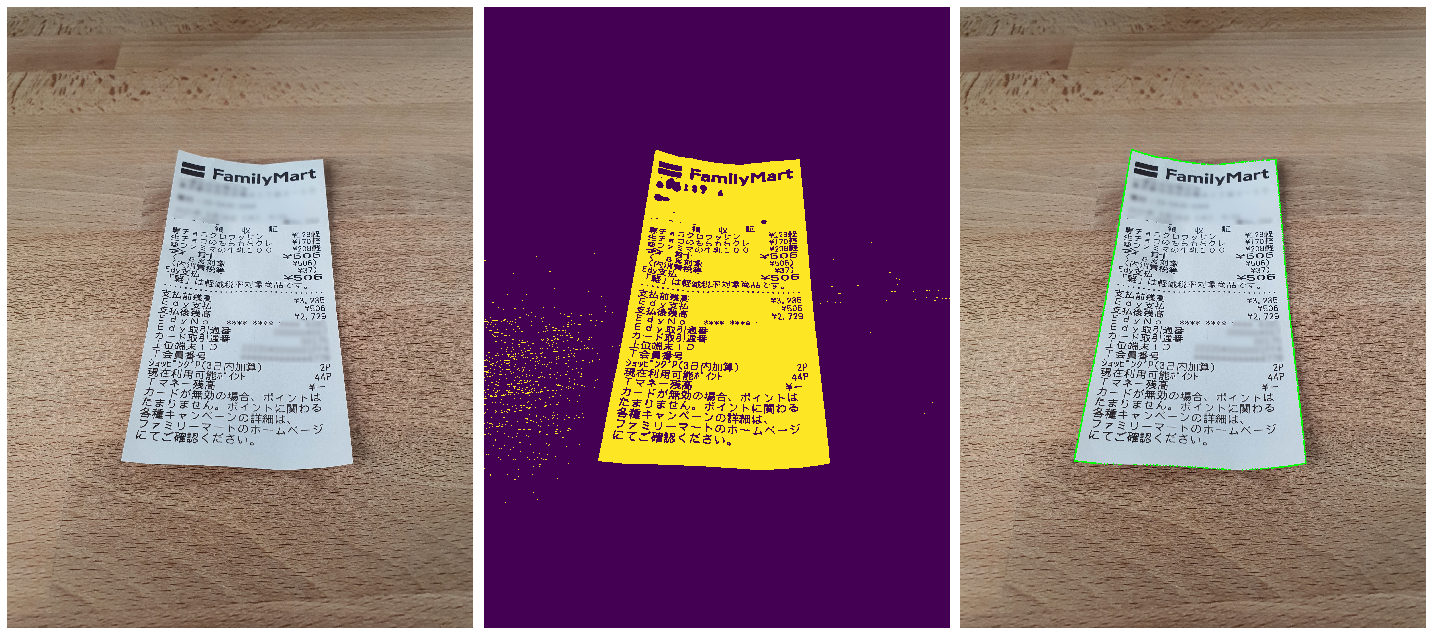

In [3]:
img = cv2.imread(path)[:, :, [2, 1, 0]]
contours, thresh = get_contours(img)
cnt = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 10)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(thresh)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cnt)
plt.axis('off')
plt.tight_layout()
plt.show()

# Contouring, bouding box and minimum enclosing

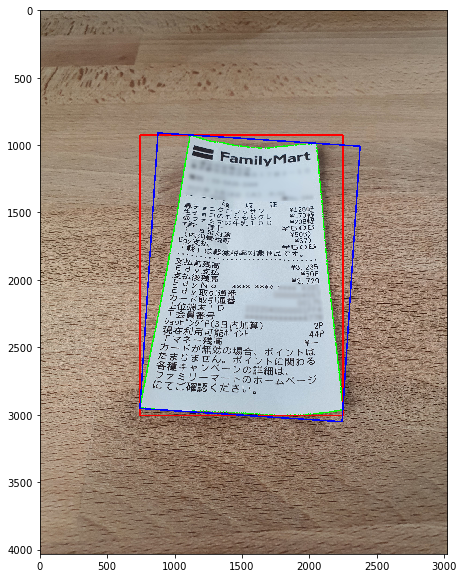

In [4]:
x, y, w, h = cv2.boundingRect(contours)
cnt = cv2.rectangle(cnt,(x,y), (x+w,y+h), (255,0,0), 10)

rect = cv2.minAreaRect(contours)
box = np.int0(cv2.boxPoints(rect))
cnt = cv2.drawContours(cnt,[box],0,(0,0,255),10)

plt.figure(figsize=(10,10))
plt.imshow(cnt)
plt.show()

# Warp correction and crop

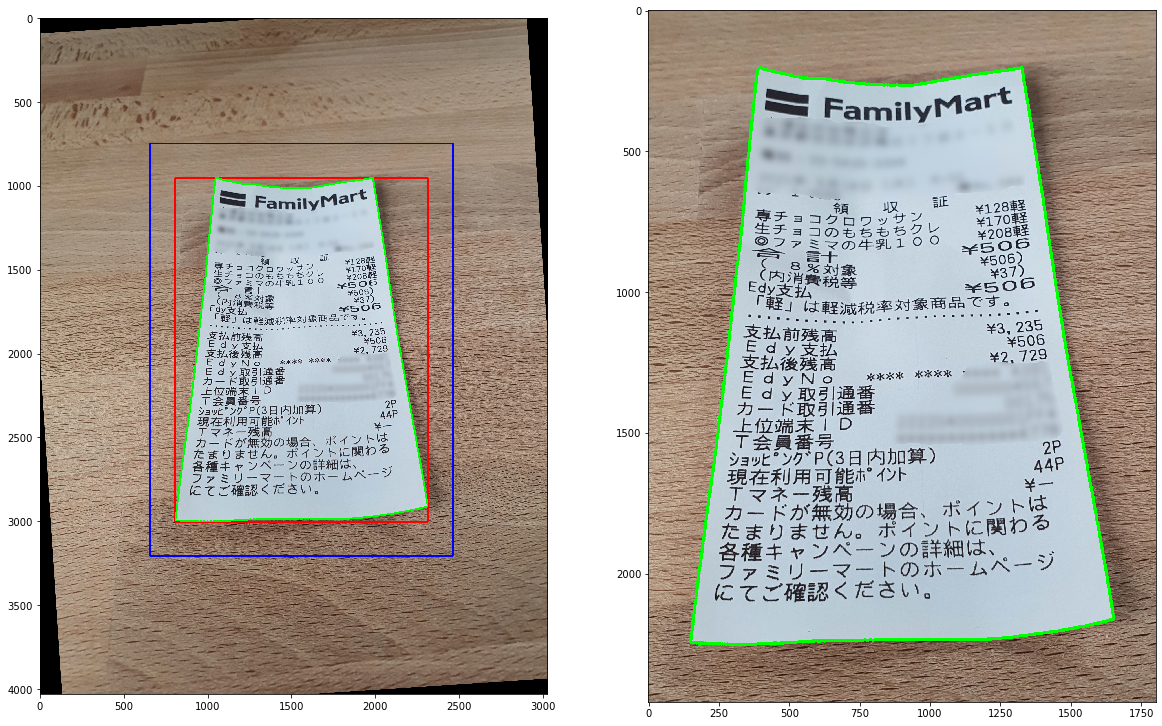

In [5]:
# 2D rotation matric from bounding box angle and center
rot = cv2.getRotationMatrix2D(rect[0], rect[2], 1)
warp = cv2.warpAffine(img, rot, (cnt.shape[1], cnt.shape[0]))

# Apply warp transformation to bounding box points
box_rot = np.hstack([box, np.ones(shape=(box.shape[0], 1))])
box_rot = np.uint(rot.dot(box_rot.T).T)

# Apply warp transformation to countour points
contours_warp = np.squeeze(np.array(contours))
contours_warp = np.hstack([contours_warp, np.ones(shape=(contours_warp.shape[0], 1))])
contours_warp = rot.dot(contours_warp.T).T

# Plot rotated box and contour
img_warp = warp.copy()
x_warp, y_warp, w_warp, h_warp = cv2.boundingRect(box_rot.astype(np.int32))
img_warp = cv2.rectangle(img_warp,(x_warp,y_warp), (x_warp+w_warp,y_warp+h_warp), (255,0,0), 10)
img_warp = cv2.drawContours(img_warp, [contours_warp.reshape(-1,1,2).astype(np.int32)], -1, (0, 255, 0), 10)

# Crop image with 10% height margin
m_h, m_w = int(0.1*h_warp), int(0.1*w_warp)
warp = warp[y_warp - m_h : y_warp + h_warp + m_h, x_warp - m_w : x_warp + w_warp + m_w]
img_warp = cv2.rectangle(img_warp,(x_warp-m_w,y_warp-m_h), (x_warp+w_warp+m_w,y_warp+h_warp+m_h), (0,0,255), 10)

# # Resize contours points (crop)
warp_res = warp.copy()
contours_warp = np.squeeze(contours_warp)
contours_warp[:,0] = (contours_warp[:,0] - (x_warp - m_w))
contours_warp[:,1] = (contours_warp[:,1] - (y_warp - m_h))
warp_res = cv2.drawContours(warp_res, [contours_warp.reshape(-1,1,2).astype(np.int32)], -1, (0, 255, 0), 10)

# Plot results
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(img_warp)
plt.subplot(1,2,2)
plt.imshow(warp_res)
plt.show()

# Edge retrieval & homography using bounding box

In [6]:
# Get edges from contour
centroids = get_centroids(warp, contours_warp)

# Sort edges in clock-wise order from top-left
pts_src, ratio = sort_points(centroids[1:].astype(int))

# Get destination points in clock-wise order from top-left
x, y, w, h = cv2.boundingRect(contours_warp.astype(np.int32))
pts_dst = np.array([[x,y], [x+w,y],[x+w,ratio*(y+h)], [x,ratio*(y+h)]]).astype(int)
pts_dst_plot = np.array([[x,y], [x+w,y],[x+w,y+h], [x,y+h]]).astype(int)

# Plot results
warp_res = cv2.rectangle(warp_res,(x,y), (x+w,y+h), (255,0,0), 10)
for i,j in zip(pts_src, pts_dst_plot):
    warp_res = cv2.circle(warp_res, (i[0], i[1]), 20, (255,255,0), 10)
    warp_res = cv2.circle(warp_res, (j[0], j[1]), 20, (0,0,255), 10)

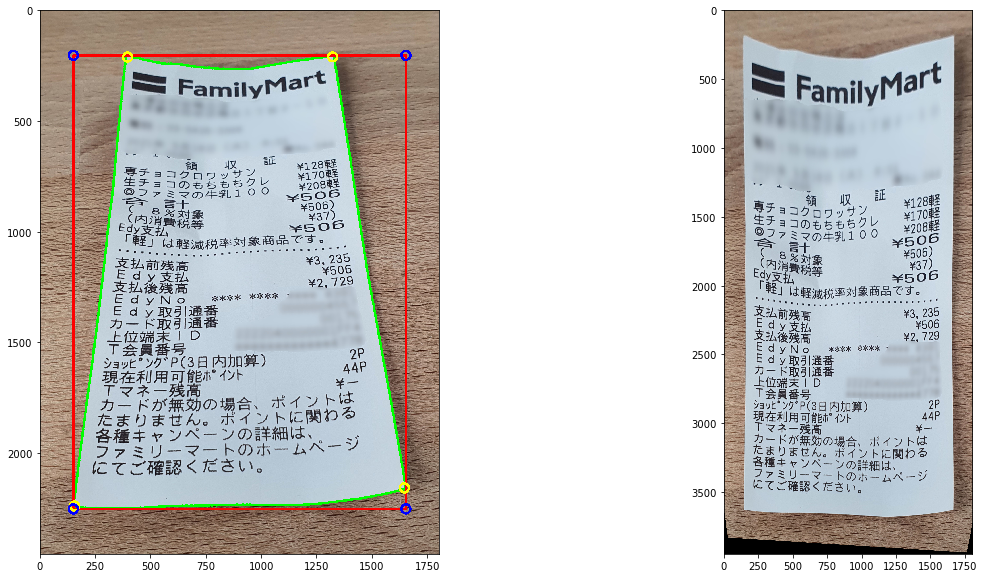

In [7]:
# pts_src and pts_dst are numpy arrays of points in source and destination images.
h, status = cv2.findHomography(pts_src, pts_dst)
height, width = warp_res.shape[:2]

# The calculated homography can be used to transform the source image.
img_dst = cv2.warpPerspective(warp.copy(), h, (width, int(height*ratio)))

# Plot results
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(warp_res)
plt.subplot(1,2,2)
plt.imshow(img_dst)
plt.show()

# Analyse contours

In [8]:
def extend_coord(pts1, pts2, factor=1.05):
    t0=0.5*(1.0-factor)
    t1=0.5*(1.0+factor)
    x1 = int(pts1[0] +(pts2[0] - pts1[0]) * t0)
    y1 = int(pts1[1] +(pts2[1] - pts1[1]) * t0)
    x2 = int(pts1[0] +(pts2[0] - pts1[0]) * t1)
    y2 = int(pts1[1] +(pts2[1] - pts1[1]) * t1)
    return [(x1,y1),(x2,y2)]

def coord_contour(r,p,axis):
    inter = r.intersection(p)
    if inter.geom_type == 'MultiLineString':
        inter = ops.linemerge(inter)
    cnt = np.array([inter.coords]).reshape(-1,2).astype(int)
    return cnt[np.argsort(cnt[:,axis])]

In [9]:
contours_homo, thresh = get_contours(img_dst)
centroids = get_centroids(img_dst, contours_homo)
edges, _ = sort_points(centroids[1:].astype(int))

# Get coordinate of lines passing by opposite edges
center = np.array((sum(edges[:,0]) / len(edges), sum(edges[:,1]) / len(edges))).astype(int)
pts_tl_br = extend_coord(edges[0], edges[2])
pts_tr_bl = extend_coord(edges[1], edges[3])

# Find interesection between line and polygon
ring = LinearRing(contours_homo.squeeze().tolist())

poly = Polygon(np.array([center,pts_tl_br[0], pts_tr_bl[0]]))
cnt_top = coord_contour(ring, poly, 0)

poly = Polygon(np.array([center,pts_tr_bl[0], pts_tl_br[1]]))
cnt_right = coord_contour(ring, poly, 1)

poly = Polygon(np.array([center,pts_tl_br[1],pts_tr_bl[1]]))
cnt_bot = coord_contour(ring, poly, 0)

poly = Polygon(np.array([center,pts_tr_bl[1],pts_tl_br[0]]))
cnt_left = coord_contour(ring, poly, 1)

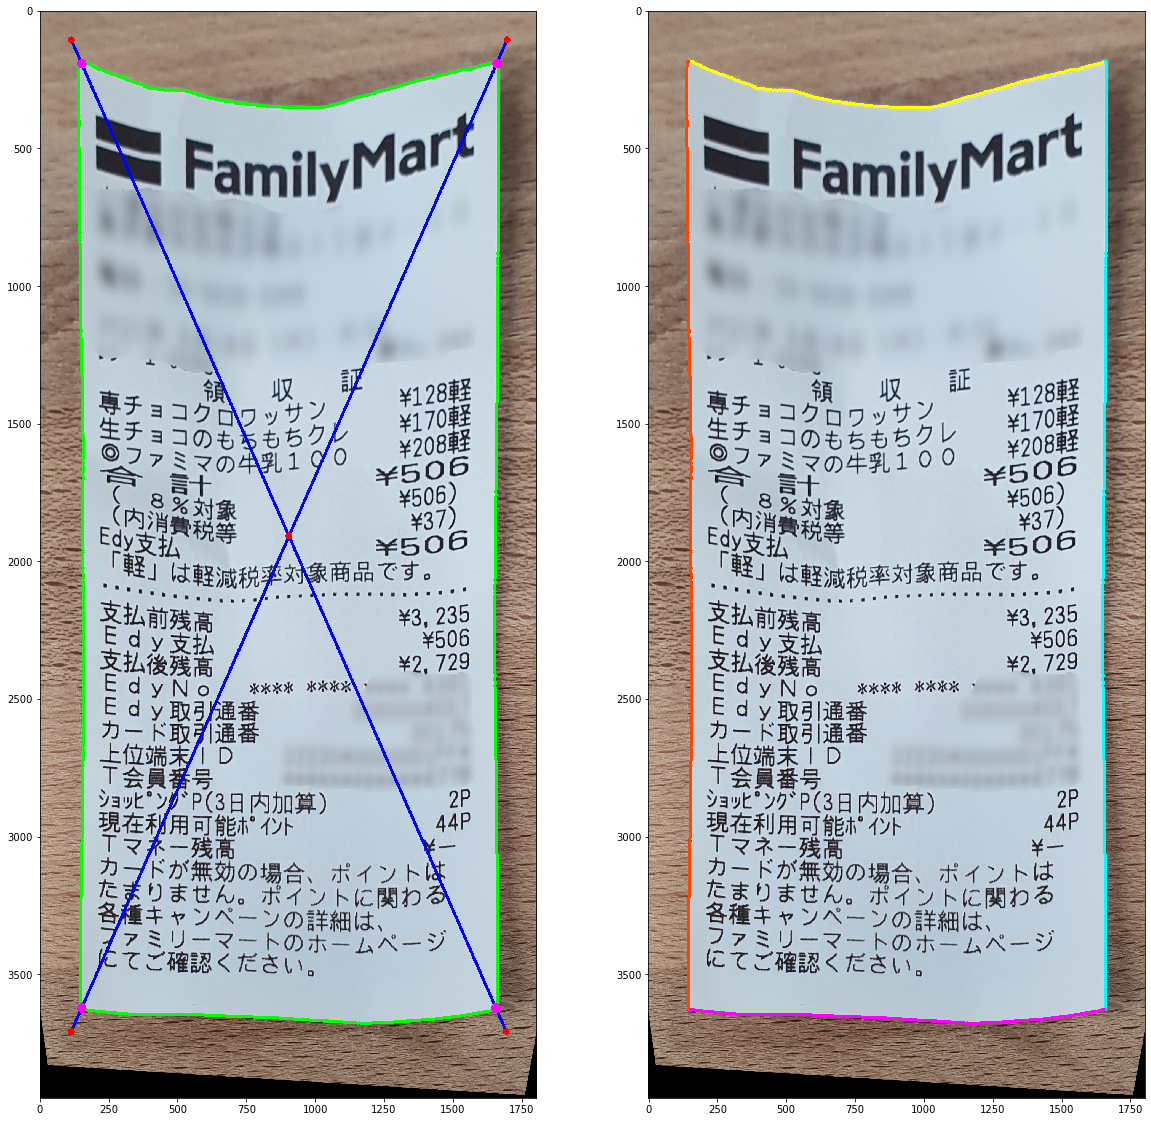

In [10]:
# Plot results
res = img_dst.copy()
res_cnt = img_dst.copy()

res = cv2.drawContours(res, [contours_homo], -1, (0, 255, 0), 10)
res = cv2.line(res, pts_tl_br[0], pts_tl_br[1], (0, 0, 255), 10)
res = cv2.line(res, pts_tr_bl[0], pts_tr_bl[1], (0, 0, 255), 10)

for i in edges:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,0), 10)
    
res = cv2.circle(res, (center[0],center[1]), 7, (255,0,0), 10)
for i in pts_tl_br:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,0), 10)
for i in pts_tr_bl:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,0), 10)

res_cnt = cv2.polylines(res_cnt, [cnt_top], 0, (255, 255, 0), 10)
res_cnt = cv2.polylines(res_cnt, [cnt_right], 0, (0, 255, 255), 10)
res_cnt = cv2.polylines(res_cnt, [cnt_bot], 0, (255, 0, 255), 10)
res_cnt = cv2.polylines(res_cnt, [cnt_left], 0, (255,69,0), 10)

for i in edges:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,255), 20)

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(res)

plt.subplot(1,2,2)
plt.imshow(res_cnt)
plt.show()

# Apply Thin plate spline transformation

In [11]:
# Create a grid from contours analysis that has 10 rows and 5 columns
row = 10
col = 5

# Linear distance grid retrieval
top_dist = distance.cdist(cnt_top, cnt_top, 'euclidean')[0]
idx_top = [0] + [np.argmin(np.abs(top_dist-i)) for i in list(np.arange(0 , col)*(top_dist[-1] / (col-1)))[1:-1]]+ [len(top_dist)-1]
top_pts = cnt_top[idx_top]

right_dist = distance.cdist(cnt_right, cnt_right, 'euclidean')[0]
idx_right = [0] + [np.argmin(np.abs(right_dist-i)) for i in list(np.arange(0 , row)*(right_dist[-1] / (row-1)))[1:-1]]+ [len(right_dist)-1]
right_pts = cnt_right[idx_right]

bot_dist = distance.cdist(cnt_bot, cnt_bot, 'euclidean')[0]
idx_bot = [0] + [np.argmin(np.abs(bot_dist-i)) for i in list(np.arange(0 , col)*(bot_dist[-1] / (col-1)))[1:-1]]+ [len(bot_dist)-1]
bot_pts = cnt_bot[idx_bot]

left_dist = distance.cdist(cnt_left, cnt_left, 'euclidean')[0]
idx_left = [0] + [np.argmin(np.abs(left_dist-i)) for i in list(np.arange(0 , row)*(left_dist[-1] / (row-1)))[1:-1]]+ [len(left_dist)-1]
left_pts = cnt_left[idx_left]

pts = []
for r, c in list(itertools.product(list(range(row)), list(range(col)))):
    if r==0:
        pts.append(top_pts[c].tolist())
    elif r == row-1:
        pts.append(bot_pts[c].tolist())
    else:
        x = np.average([left_pts[r][0], right_pts[r][0]], weights=[(col -1 -c)/(col-1), c/(col -1)])
        y = np.average([top_pts[c][1], bot_pts[c][1]], weights=[(row -1 -r)/(row-1), r/(row-1)])
        pts.append([int(x),int(y)])

pts_grid = []

x = np.linspace(left_pts[0][0], right_pts[0][0], col)
y = np.linspace(top_pts[0][1], bot_pts[0][1], row)
xv, yv = np.meshgrid(x, y)

pts_grid = list(zip(xv.ravel().astype(int).tolist(),yv.ravel().astype(int).tolist()))

tps = cv2.createThinPlateSplineShapeTransformer()
matches = [cv2.DMatch(i, i, 0) for i in range(len(pts))]

tps.estimateTransformation(np.array(pts_grid).reshape(1,-1,2), np.array(pts).reshape(1,-1,2), matches)
out_img = tps.warpImage(img_dst.copy())

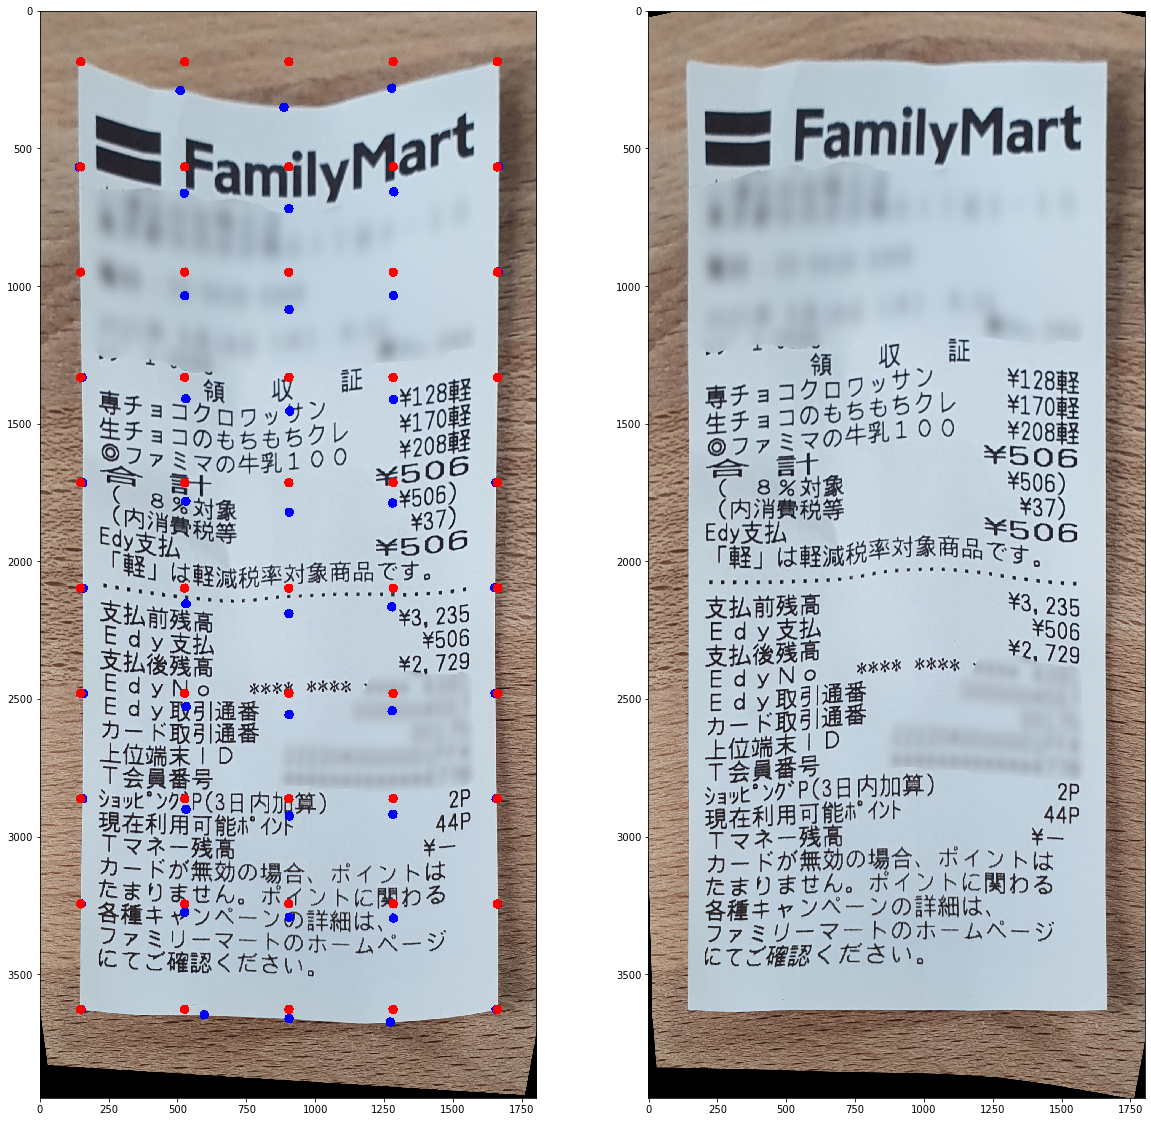

In [12]:
# Plot results
for i in pts:
    img_dst = cv2.circle(img_dst, (i[0], i[1]), 7, (0,0,255), 20)

for i in pts_grid:
    img_dst = cv2.circle(img_dst, (i[0], i[1]), 7, (255,0,0), 20)
    
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(img_dst)
plt.subplot(1,2,2)
plt.imshow(out_img)
plt.show()